In [1]:
import os
import gc
import time
import pickle
import datetime
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask import delayed, compute
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing, metrics
import lightgbm as lgb
from textblob import TextBlob

path = "F:\\Pratik\\LearningZone\\Competitions\\Avito_Demand_Prediction_Challenge"
os.chdir(path)

C:\Program Files\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
train_df = pd.read_csv('train_translated.csv', parse_dates=['activation_date'])
test_df = pd.read_csv('test_translated.csv', parse_dates=['activation_date'])

In [9]:
train_df['dow'] = train_df['activation_date'].dt.weekday
test_df['dow'] = test_df['activation_date'].dt.weekday

In [ ]:
train_df.head()

In [10]:
cat_vars = ["en_region", "en_city", "en_parent_category_name", "en_category_name", "user_type", "en_param1", "en_param2", "en_param3"]

In [11]:
def label_encoding(train_data, categorical_feature_names):
    le = preprocessing.LabelEncoder() # Defining Label Encoder
    train_cat_features = np.array(train_data[categorical_feature_names])
    train_data_array = le.fit_transform(train_cat_features[:,0])
    for i in range(1,train_cat_features.shape[1]):
        train_data_array = np.column_stack((train_data_array, le.fit_transform(train_cat_features[:,i])))
        
    train_cat_data_df = pd.DataFrame(train_data_array, columns=categorical_feature_names)
    return train_cat_data_df[categorical_feature_names]

In [13]:
train_df[['en_param1','en_param2','en_param3']].fillna('Missing', inplace=True)
test_df[['en_param1','en_param2','en_param3']].fillna('Missing', inplace=True)

C:\Program Files\Anaconda\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [14]:
train_df['en_param1'] = train_df['en_param1'].map(str)
train_df['en_param2'] = train_df['en_param2'].map(str)
train_df['en_param3'] = train_df['en_param3'].map(str)

In [15]:
test_df['en_param1'] = test_df['en_param1'].map(str)
test_df['en_param2'] = test_df['en_param2'].map(str)
test_df['en_param3'] = test_df['en_param3'].map(str)

In [16]:
Catg_Var_LE_train = label_encoding(train_df,cat_vars)
Catg_Var_LE_test = label_encoding(test_df,cat_vars)

In [17]:
# Dropping the rows on which One-Hot Encoding has been performed
train_df = train_df.drop(Catg_Var_LE_train.columns, axis=1)
# Concating the rows converted using One-Hot Encoding to other columns:
train_df = pd.concat([train_df,Catg_Var_LE_train], axis=1)

In [18]:
# Dropping the rows on which One-Hot Encoding has been performed
test_df = test_df.drop(Catg_Var_LE_test.columns, axis=1)
# Concating the rows converted using One-Hot Encoding to other columns:
test_df = pd.concat([test_df,Catg_Var_LE_test], axis=1)

In [46]:
target = 'deal_probability'
predictors = ['dow', 'en_region', 'en_city',
       'en_parent_category_name', 'en_category_name', 'user_type', 'en_param1',
       'en_param2', 'en_param3','price_new']

In [47]:
# Splitting the data for model training#
dev_X = train_df.iloc[:-200000,:]
val_X = train_df.iloc[-200000:,:]

In [48]:
def run_lgb(train_X, val_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values)
    lgval = lgb.Dataset(val_X[predictors].values, label=val_X[target].values)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    #pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return model, evals_result

In [49]:
model, result = run_lgb(dev_X, val_X)

Training until validation scores don't improve for 100 rounds.
[20]	training's rmse: 0.236636	valid_1's rmse: 0.236923
[40]	training's rmse: 0.234309	valid_1's rmse: 0.23463
[60]	training's rmse: 0.233294	valid_1's rmse: 0.233631
[80]	training's rmse: 0.232652	valid_1's rmse: 0.233015
[100]	training's rmse: 0.232152	valid_1's rmse: 0.232557
[120]	training's rmse: 0.231786	valid_1's rmse: 0.232226
[140]	training's rmse: 0.231433	valid_1's rmse: 0.23191
[160]	training's rmse: 0.231173	valid_1's rmse: 0.231688
[180]	training's rmse: 0.230931	valid_1's rmse: 0.2315
[200]	training's rmse: 0.23073	valid_1's rmse: 0.231351
[220]	training's rmse: 0.230574	valid_1's rmse: 0.231244
[240]	training's rmse: 0.230438	valid_1's rmse: 0.231156
[260]	training's rmse: 0.230273	valid_1's rmse: 0.231035
[280]	training's rmse: 0.23014	valid_1's rmse: 0.230954
[300]	training's rmse: 0.230007	valid_1's rmse: 0.230872
[320]	training's rmse: 0.229875	valid_1's rmse: 0.230797
[340]	training's rmse: 0.22977	vali

In [50]:
test_df['deal_probability'] = model.predict(test_df[predictors])

In [53]:
test_df[['item_id','deal_probability']].to_csv('base_submission_including_price.csv', index=False)

In [35]:
len(test_df)

508438

In [52]:
test_df.deal_probability[test_df['deal_probability'] < 0] = 0

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
import kaggle

In [54]:
!kaggle competitions submit -c avito-demand-prediction -f base_submission_including_price.csv -m "Base Submissions with Price"

Successfully submitted to Avito Demand Prediction Challenge


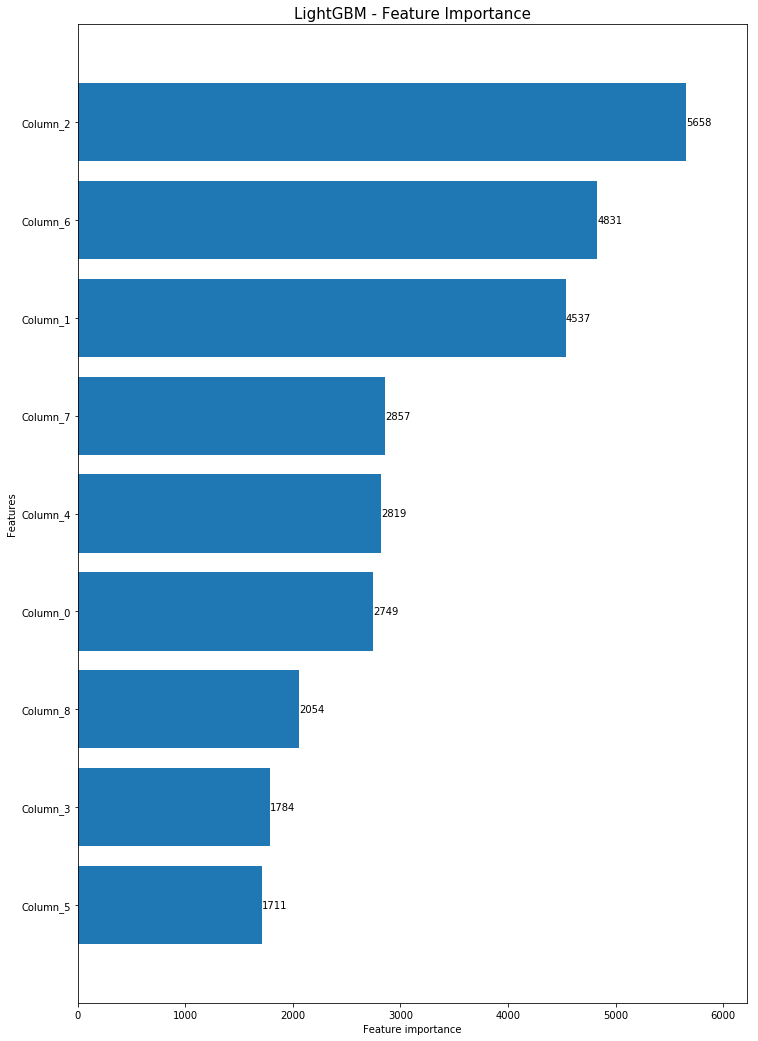

In [23]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()